In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==1.14

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from time import time
from scipy.sparse import csc_matrix
import tensorflow as tf
import numpy as np
import h5py

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
print(tf.__version__)

1.14.0


## Data Loader Function

In [ ]:
def load_data_100k(path='./', delimiter='\t'):

    train = np.loadtxt(path+'movielens_100k_u1.base', skiprows=0, delimiter=delimiter).astype('int32')
    test = np.loadtxt(path+'movielens_100k_u1.test', skiprows=0, delimiter=delimiter).astype('int32')
    total = np.concatenate((train, test), axis=0)

    n_u = np.unique(total[:,0]).size  # num of users
    n_m = np.unique(total[:,1]).size  # num of movies
    n_train = train.shape[0]  # num of training ratings
    n_test = test.shape[0]  # num of test ratings

    train_r = np.zeros((n_m, n_u), dtype='float32')
    test_r = np.zeros((n_m, n_u), dtype='float32')

    for i in range(n_train):
        train_r[train[i,1]-1, train[i,0]-1] = train[i,2]

    for i in range(n_test):
        test_r[test[i,1]-1, test[i,0]-1] = test[i,2]

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')

    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_train))
    print('num of test ratings: {}'.format(n_test))

    return n_m, n_u, train_r, train_m, test_r, test_m

In [ ]:
def load_data_1m(path='./', delimiter='::', frac=0.05, seed=1234):

    tic = time()
    print('reading data...')
    data = np.loadtxt(path+'movielens_1m_dataset.dat', skiprows=0, delimiter=delimiter).astype('int32')
    print('taken', time() - tic, 'seconds')

    n_u = np.unique(data[:,0]).size  # num of users
    n_m = np.unique(data[:,1]).size  # num of movies
    n_r = data.shape[0]  # num of ratings

    udict = {}
    for i, u in enumerate(np.unique(data[:,0]).tolist()):
        udict[u] = i
    mdict = {}
    for i, m in enumerate(np.unique(data[:,1]).tolist()):
        mdict[m] = i

    np.random.seed(seed)
    idx = np.arange(n_r)
    np.random.shuffle(idx)

    train_r = np.zeros((n_m, n_u), dtype='float32')
    test_r = np.zeros((n_m, n_u), dtype='float32')

    for i in range(n_r):
        u_id = data[idx[i], 0]
        m_id = data[idx[i], 1]
        r = data[idx[i], 2]

        if i < int(frac * n_r):
            test_r[mdict[m_id], udict[u_id]] = r
        else:
            train_r[mdict[m_id], udict[u_id]] = r

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')

    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_r - int(frac * n_r)))
    print('num of test ratings: {}'.format(int(frac * n_r)))

    return n_m, n_u, train_r, train_m, test_r, test_m

In [ ]:
def load_matlab_file(path_file, name_field):
    
    db = h5py.File(path_file, 'r')
    ds = db[name_field]

    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

In [ ]:
def load_data_monti(path='./'):

    M = load_matlab_file(path+'douban_monti_dataset.mat', 'M')
    Otraining = load_matlab_file(path+'douban_monti_dataset.mat', 'Otraining') * M
    Otest = load_matlab_file(path+'douban_monti_dataset.mat', 'Otest') * M

    n_u = M.shape[0]  # num of users
    n_m = M.shape[1]  # num of movies
    n_train = Otraining[np.where(Otraining)].size  # num of training ratings
    n_test = Otest[np.where(Otest)].size  # num of test ratings

    train_r = Otraining.T
    test_r = Otest.T

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')

    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_train))
    print('num of test ratings: {}'.format(n_test))

    return n_m, n_u, train_r, train_m, test_r, test_m

In [ ]:
# Insert the path of a data directory by yourself (e.g., '/content/.../data')
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
data_path = '/content/drive/MyDrive/data/'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._

In [ ]:
# Select a dataset among 'ML-1M', 'ML-100K', and 'Douban'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
dataset = 'ML-1M'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._

In [ ]:
# Data Load
try:
    if dataset == 'ML-100K':
        path = data_path + '/MovieLens_100K/'
        n_m, n_u, train_r, train_m, test_r, test_m = load_data_100k(path=path, delimiter='\t')

    elif dataset == 'ML-1M':
        path = data_path + '/MovieLens_1M/'
        n_m, n_u, train_r, train_m, test_r, test_m = load_data_1m(path=path, delimiter='::', frac=0.1, seed=1234)

    elif dataset == 'Douban':
        path = data_path + '/Douban_monti/'
        n_m, n_u, train_r, train_m, test_r, test_m = load_data_monti(path=path)

    else:
        raise ValueError

except ValueError:
    print('Error: Unable to load data')

reading data...
taken 7.3984129428863525 seconds
data matrix loaded
num of users: 6040
num of movies: 3706
num of training ratings: 900189
num of test ratings: 100020


# Hyperparameter Settings

In [ ]:
# Common hyperparameter settings
n_hid = 500
n_dim = 5
n_layers = 2
gk_size = 3

In [ ]:
# Different hyperparameter settings for each dataset
if dataset == 'ML-100K':
    lambda_2 = 20.  # l2 regularisation
    lambda_s = 0.006
    iter_p = 5  # optimisation
    iter_f = 5
    epoch_p = 30  # training epoch
    epoch_f = 60
    dot_scale = 1  # scaled dot product

elif dataset == 'ML-1M':
    lambda_2 = 70.
    lambda_s = 0.018
    iter_p = 50
    iter_f = 10
    epoch_p = 20
    epoch_f = 30
    dot_scale = 0.5

elif dataset == 'Douban':
    lambda_2 = 10.
    lambda_s = 0.022
    iter_p = 5
    iter_f = 5
    epoch_p = 20
    epoch_f = 60
    dot_scale = 2

In [ ]:
R = tf.placeholder("float", [n_m, n_u])

# Network Function

In [ ]:
def local_kernel(u, v):

    dist = tf.norm(u - v, ord=2, axis=2)
    hat = tf.maximum(0., 1. - dist**2)

    return hat

In [ ]:
def kernel_layer(x, n_hid=n_hid, n_dim=n_dim, activation=tf.nn.sigmoid, lambda_s=lambda_s, lambda_2=lambda_2, name=''):

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        W = tf.get_variable('W', [x.shape[1], n_hid])
        n_in = x.get_shape().as_list()[1]
        u = tf.get_variable('u', initializer=tf.random.truncated_normal([n_in, 1, n_dim], 0., 1e-3))
        v = tf.get_variable('v', initializer=tf.random.truncated_normal([1, n_hid, n_dim], 0., 1e-3))
        b = tf.get_variable('b', [n_hid])

    w_hat = local_kernel(u, v)
    
    sparse_reg = tf.contrib.layers.l2_regularizer(lambda_s)
    sparse_reg_term = tf.contrib.layers.apply_regularization(sparse_reg, [w_hat])
    
    l2_reg = tf.contrib.layers.l2_regularizer(lambda_2)
    l2_reg_term = tf.contrib.layers.apply_regularization(l2_reg, [W])

    W_eff = W * w_hat  # Local kernelised weight matrix
    y = tf.matmul(x, W_eff) + b
    y = activation(y)

    return y, sparse_reg_term + l2_reg_term

In [ ]:
def global_kernel(input, gk_size, dot_scale):

    avg_pooling = tf.reduce_mean(input, axis=1)  # Item (axis=1) based average pooling
    avg_pooling = tf.reshape(avg_pooling, [1, -1])
    n_kernel = avg_pooling.shape[1].value

    conv_kernel = tf.get_variable('conv_kernel', initializer=tf.random.truncated_normal([n_kernel, gk_size**2], stddev=0.1))
    gk = tf.matmul(avg_pooling, conv_kernel) * dot_scale  # Scaled dot product
    gk = tf.reshape(gk, [gk_size, gk_size, 1, 1])

    return gk

In [ ]:
def global_conv(input, W):

    input = tf.reshape(input, [1, input.shape[0], input.shape[1], 1])
    conv2d = tf.nn.relu(tf.nn.conv2d(input, W, strides=[1,1,1,1], padding='SAME'))

    return tf.reshape(conv2d, [conv2d.shape[1], conv2d.shape[2]])

# Network Instantiation

# Pre-training

In [ ]:
y = R
reg_losses = None

for i in range(n_layers):
    y, reg_loss = kernel_layer(y, name=str(i))
    reg_losses = reg_loss if reg_losses is None else reg_losses + reg_loss

pred_p, reg_loss = kernel_layer(y, n_u, activation=tf.identity, name='out')
reg_losses = reg_losses + reg_loss

# L2 loss
diff = train_m * (train_r - pred_p)
sqE = tf.nn.l2_loss(diff)
loss_p = sqE + reg_losses

optimizer_p = tf.contrib.opt.ScipyOptimizerInterface(loss_p, options={'disp': True, 'maxiter': iter_p, 'maxcor': 10}, method='L-BFGS-B')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Fine-tuning


In [ ]:
y = R
reg_losses = None

for i in range(n_layers):
    y, _ = kernel_layer(y, name=str(i))

y_dash, _ = kernel_layer(y, n_u, activation=tf.identity, name='out')

gk = global_kernel(y_dash, gk_size, dot_scale)  # Global kernel
y_hat = global_conv(train_r, gk)  # Global kernel-based rating matrix

for i in range(n_layers):
    y_hat, reg_loss = kernel_layer(y_hat, name=str(i))
    reg_losses = reg_loss if reg_losses is None else reg_losses + reg_loss

pred_f, reg_loss = kernel_layer(y_hat, n_u, activation=tf.identity, name='out')
reg_losses = reg_losses + reg_loss

# L2 loss
diff = train_m * (train_r - pred_f)
sqE = tf.nn.l2_loss(diff)
loss_f = sqE + reg_losses

optimizer_f = tf.contrib.opt.ScipyOptimizerInterface(loss_f, options={'disp': True, 'maxiter': iter_f, 'maxcor': 10}, method='L-BFGS-B')

# Evaluation code

In [ ]:
def dcg_k(score_label, k):
    dcg, i = 0., 0
    for s in score_label:
        if i < k:
            dcg += (2**s[1]-1) / np.log2(2+i)
            i += 1
    return dcg

In [ ]:
def ndcg_k(y_hat, y, k):
    score_label = np.stack([y_hat, y], axis=1).tolist()
    score_label = sorted(score_label, key=lambda d:d[0], reverse=True)
    score_label_ = sorted(score_label, key=lambda d:d[1], reverse=True)
    norm, i = 0., 0
    for s in score_label_:
        if i < k:
            norm += (2**s[1]-1) / np.log2(2+i)
            i += 1
    dcg = dcg_k(score_label, k)
    return dcg / norm

In [ ]:
def call_ndcg(y_hat, y):
    ndcg_sum, num = 0, 0
    y_hat, y = y_hat.T, y.T
    n_users = y.shape[0]

    for i in range(n_users):
        y_hat_i = y_hat[i][np.where(y[i])]
        y_i = y[i][np.where(y[i])]

        if y_i.shape[0] < 2:
            continue

        ndcg_sum += ndcg_k(y_hat_i, y_i, y_i.shape[0])  # user-wise calculation
        num += 1

    return ndcg_sum / num

# Training and Test Loop

In [ ]:
best_rmse_ep, best_mae_ep, best_ndcg_ep = 0, 0, 0
best_rmse, best_mae, best_ndcg = float("inf"), float("inf"), 0

time_cumulative = 0
init = tf.global_variables_initializer()
Epoches_pre = []
Train_mse_pre = []
Test_mse_pre = []
Epoches_ft = []
Train_mse_ft = []
Test_mse_ft = []
Train_mae_ft = []
Test_mae_ft = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(epoch_p):
        tic = time()
        optimizer_p.minimize(sess, feed_dict={R: train_r})
        pre = sess.run(pred_p, feed_dict={R: train_r})

        t = time() - tic
        time_cumulative += t
        
        error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
        test_rmse = np.sqrt(error)

        error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
        train_rmse = np.sqrt(error_train)

        print('.-^-._' * 12)
        print('PRE-TRAINING')
        Epoches_pre.append(i+1)
        Train_mse_pre.append(error_train)
        Test_mse_pre.append(error)

        print('Epoch:', i+1, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
        print('Time:', t, 'seconds')
        print('Time cumulative:', time_cumulative, 'seconds')
        print('.-^-._' * 12)

    for i in range(epoch_f):
        tic = time()
        optimizer_f.minimize(sess, feed_dict={R: train_r})
        pre = sess.run(pred_f, feed_dict={R: train_r})

        t = time() - tic
        time_cumulative += t
        
        error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
        test_rmse = np.sqrt(error)

        error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
        train_rmse = np.sqrt(error_train)

        test_mae = (test_m * np.abs(np.clip(pre, 1., 5.) - test_r)).sum() / test_m.sum()
        train_mae = (train_m * np.abs(np.clip(pre, 1., 5.) - train_r)).sum() / train_m.sum()

        test_ndcg = call_ndcg(np.clip(pre, 1., 5.), test_r)
        train_ndcg = call_ndcg(np.clip(pre, 1., 5.), train_r)

        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_rmse_ep = i+1

        if test_mae < best_mae:
            best_mae = test_mae
            best_mae_ep = i+1

        if best_ndcg < test_ndcg:
            best_ndcg = test_ndcg
            best_ndcg_ep = i+1

        Epoches_ft.append(i+1)
        Train_mse_ft.append(error_train)
        Test_mse_ft.append(error)
        Train_mae_ft.append(train_mae)
        Test_mae_ft.append(test_mae)

        print('.-^-._' * 12)
        print('FINE-TUNING')
        print('Epoch:', i+1, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
        print('Epoch:', i+1, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
        print('Time:', t, 'seconds')
        print('Time cumulative:', time_cumulative, 'seconds')
        print('.-^-._' * 12)

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 1 test rmse: 0.8854638 train rmse: 0.8709577
Time: 226.69992685317993 seconds
Time cumulative: 226.69992685317993 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 2 test rmse: 0.8549531 train rmse: 0.81928015
Time: 191.20885181427002 seconds
Time cumulative: 417.90877866744995 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 3 test rmse: 0.84032935 train rmse: 0.78956896
Time: 197.64272594451904 seconds
Time cumulative: 615.551504611969 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 4 test rmse: 0.8342424 train rmse: 0.76804

In [ ]:
# Final result
print('Epoch:', best_rmse_ep, ' best rmse:', best_rmse)
print('Epoch:', best_mae_ep, ' best mae:', best_mae)
print('Epoch:', best_ndcg_ep, ' best ndcg:', best_ndcg)

Epoch: 27  best rmse: 0.8232812
Epoch: 27  best mae: 0.64175737
Epoch: 23  best ndcg: 0.9286854494421314


Text(0.5, 1.0, 'Training and Validation MSE in Global-K pretraining')

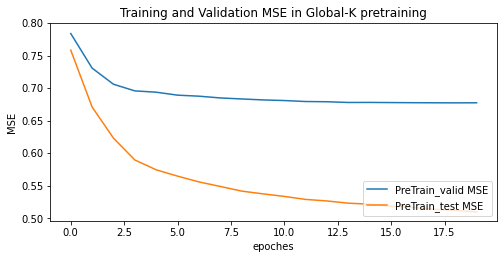

In [ ]:
import matplotlib.pyplot as plt
#

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Test_mse_pre, label='PreTrain_valid MSE')
plt.plot(Train_mse_pre, label='PreTrain_test MSE')
plt.legend(loc='lower right')
plt.xlabel('epoches')
plt.ylabel('MSE')
plt.ylim([min(plt.ylim()),0.8])
plt.title('Training and Validation MSE in Global-K pretraining')


Text(0.5, 1.0, 'Training and Validation MSE in Global-K Finetuning')

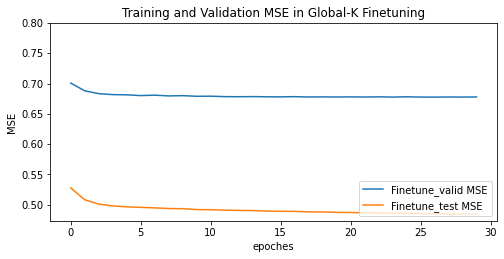

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Test_mse_ft, label='Finetune_valid MSE')
plt.plot(Train_mse_ft, label='Finetune_test MSE')
plt.legend(loc='lower right')
plt.xlabel('epoches')
plt.ylabel('MSE')
plt.ylim([min(plt.ylim()),0.8])
plt.title('Training and Validation MSE in Global-K Finetuning')

Text(0.5, 1.0, 'Training and Validation MAE in Global-K Finetuning')

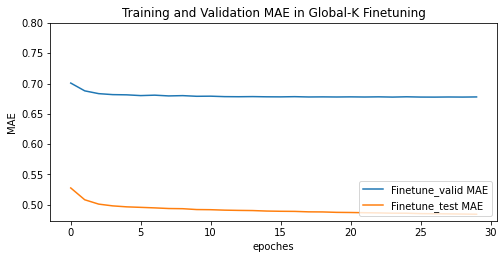

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Test_mse_ft, label='Finetune_valid MAE')
plt.plot(Train_mse_ft, label='Finetune_test MAE')
plt.legend(loc='lower right')
plt.xlabel('epoches')
plt.ylabel('MAE')
plt.ylim([min(plt.ylim()),0.8])
plt.title('Training and Validation MAE in Global-K Finetuning')